# Fine-Tuning a Transformer Model for Classification
## Benchmark Model for Comparison
https://huggingface.co/spaces/mteb/leaderboard

## 01 Load Data

In [1]:
pip install torch transformers sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import zipfile
from scipy.sparse import load_npz
import re
import os
import numpy as np

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
from transformers import AdamW
from torch.amp import autocast, GradScaler
from transformers import AutoConfig
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

In [26]:
train_data = pd.read_csv('../02_data/train_test/train_data.csv')
test_data = pd.read_csv('../02_data/train_test/test_data.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4753 entries, 0 to 4752
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   domain             4753 non-null   object 
 1   domain_index       4753 non-null   int64  
 2   url_index          4753 non-null   int64  
 3   article            4753 non-null   object 
 4   article_embedding  4753 non-null   object 
 5   virality           4753 non-null   float64
 6   avalanches         4753 non-null   float64
 7   messages           4753 non-null   float64
 8   chats              4753 non-null   float64
 9   year               4753 non-null   float64
 10  pc1                4753 non-null   float64
 11  label              4753 non-null   int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 445.7+ KB


In [27]:
train_data.describe()

,domain_index,url_index,virality,avalanches,messages,chats,year,pc1,label
count,4753.000000,4.753000e+03,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000
mean,2982.727330,1.741486e+07,0.802281,7.609510,16.787292,4.802230,2021.705660,0.595997,0.745845
std,1705.399301,1.522709e+07,0.268776,89.025177,343.288119,22.286265,1.442152,0.198638,0.435431
min,0.000000,1.621000e+03,0.015675,1.000000,1.000000,1.000000,2016.000000,0.000000,0.000000
25%,1519.000000,5.006701e+06,0.600000,1.000000,1.000000,1.000000,2021.000000,0.493744,0.000000
50%,2987.000000,1.284975e+07,1.000000,1.000000,1.000000,1.000000,2022.000000,0.629671,1.000000
75%,4446.000000,2.724570e+07,1.000000,3.000000,4.000000,2.000000,2023.000000,0.723936,1.000000
max,5941.000000,6.071784e+07,1.000000,5678.000000,22789.000000,572.000000,2023.000000,0.998049,1.000000


## 02 Preprocessing

In [28]:
train_data['label'] = pd.cut(train_data['pc1'], bins=[-float('inf'), 0.33, 0.66, float('inf')], labels=[0, 1, 2]).astype(int)
test_data['label'] = pd.cut(test_data['pc1'], bins=[-float('inf'), 0.33, 0.66, float('inf')], labels=[0, 1, 2]).astype(int)

train_data["label"].value_counts(normalize=True) * 100  # Percentage of each class

label
1    44.329897
2    41.384389
0    14.285714
Name: proportion, dtype: float64

In [6]:
# removing special characters
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Záéíóúãõç\s]', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
train_data['article'] = train_data['article'].apply(preprocess_text)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4753 entries, 0 to 4752
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   domain             4753 non-null   object 
 1   domain_index       4753 non-null   int64  
 2   url_index          4753 non-null   int64  
 3   article            4753 non-null   object 
 4   article_embedding  4753 non-null   object 
 5   virality           4753 non-null   float64
 6   avalanches         4753 non-null   float64
 7   messages           4753 non-null   float64
 8   chats              4753 non-null   float64
 9   year               4753 non-null   float64
 10  pc1                4753 non-null   float64
 11  label              4753 non-null   int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 445.7+ KB


## 03 Dataset

In [24]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['article'], train_data['label'], test_size=0.2, random_state=42
)

test_labels = test_data['label'].tolist()  
test_texts = test_data['article'].tolist()

In [10]:
# Tokenize data
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512, return_tensors="pt") # >>512 characters per article?
test_encodings = tokenizer(list(test_data['article']), truncation=True, padding=True, max_length=512, return_tensors="pt") 
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512, return_tensors="pt")


In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = Dataset(train_encodings, train_labels.tolist())
test_dataset = Dataset(test_encodings, test_data['label'].tolist())
val_dataset = Dataset(val_encodings, val_labels.tolist())

## 04 Model Training

In [12]:
# Check if GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [13]:
scaler = GradScaler()  

In [14]:
pip install 'accelerate>=0.26.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file
Note: you may need to restart the kernel to use updated packages.


In [15]:
# load model
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 3
#config.hidden_dropout_prob = 0.3  # Try increasing to 0.3 or 0.4
#config.attention_probs_dropout_prob = 0.3

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1

In [16]:
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01) # 5e-5 Add weight decay to reduce overfitting:

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,  # Adjust epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir="./logs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train Model
trainer.train()

# Evaluate Model
trainer.evaluate()

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.032769
2,0.816900,1.082450
3,0.660300,1.310298


{'eval_loss': 1.0327686071395874,
 'eval_runtime': 0.6965,
 'eval_samples_per_second': 1365.448,
 'eval_steps_per_second': 170.861,
 'epoch': 3.0}

## 05 Evaluation

[2 1 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.42      0.42       137
           1       0.47      0.34      0.39       428
           2       0.48      0.63      0.54       386

    accuracy                           0.47       951
   macro avg       0.46      0.46      0.45       951
weighted avg       0.47      0.47      0.46       951



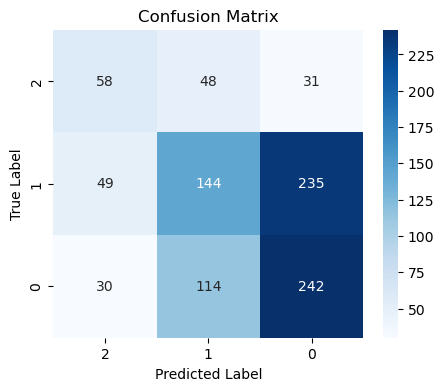

In [25]:
# Evaluate the model on the test set
predictions = trainer.predict(val_dataset)
logits = predictions.predictions
probabilities = F.softmax(torch.tensor(logits), dim=-1).numpy()
y_pred = np.argmax(probabilities, axis=1)
y_true = val_labels
unique_train_labels = val_labels.unique()
print(unique_train_labels)

# confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, labels=[0,1,2])
print("Classification Report:\n", class_report)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', yticklabels=unique_train_labels, xticklabels=unique_train_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('../03_plots/con_matrix_bert.png') #, dpi=300, bbox_inches="tight"
plt.show()